Data Initialization

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Applying data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation and test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the datasets with new transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Re-split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Data loaders
batch_size=128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=5)


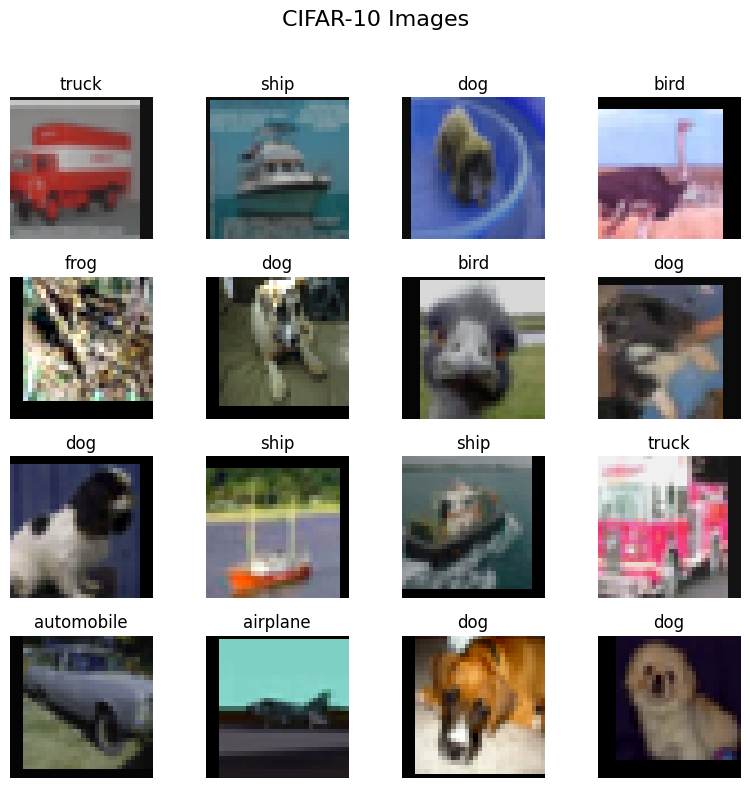

In [3]:
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(train_loader))

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to unnormalize and convert the images to numpy format
def unnormalize(img):
    img = img / 2 + 0.5  # unnormalize
    return np.transpose(img.numpy(), (1, 2, 0))  # convert from Tensor image to numpy

# Display images in a grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("CIFAR-10 Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(unnormalize(images[i]))
    ax.set_title(classes[labels[i]])
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Baseline CNN Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

        # Pooling and dropout layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# CNN
baseline_model = BaselineCNN().to(device)


In [20]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# Use of Adam optimizer
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# DataLoaders (reusing train_loader and val_loader)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training the baseline CNN model
train_losses, val_losses, train_accuracies, val_accuracies = train(
    baseline_model, train_loader, val_loader, optimizer, criterion, num_epochs
)

# Testing the baseline CNN model
test(baseline_model, test_loader)


Epoch [1/10], Train Loss: 0.6377,  Train Accuracy: 0.7782, Val Loss: 0.6845, Val Accuracy: 0.7658
Epoch [2/10], Train Loss: 0.6284,  Train Accuracy: 0.7798, Val Loss: 0.6993, Val Accuracy: 0.7595
Epoch [3/10], Train Loss: 0.6164,  Train Accuracy: 0.7828, Val Loss: 0.6683, Val Accuracy: 0.7728
Epoch [4/10], Train Loss: 0.6170,  Train Accuracy: 0.7841, Val Loss: 0.6709, Val Accuracy: 0.7722
Epoch [5/10], Train Loss: 0.6086,  Train Accuracy: 0.7902, Val Loss: 0.6756, Val Accuracy: 0.7721
Epoch [6/10], Train Loss: 0.6040,  Train Accuracy: 0.7890, Val Loss: 0.6427, Val Accuracy: 0.7806
Epoch [7/10], Train Loss: 0.5950,  Train Accuracy: 0.7913, Val Loss: 0.6873, Val Accuracy: 0.7734
Epoch [8/10], Train Loss: 0.5893,  Train Accuracy: 0.7948, Val Loss: 0.6550, Val Accuracy: 0.7794
Epoch [9/10], Train Loss: 0.5884,  Train Accuracy: 0.7956, Val Loss: 0.6798, Val Accuracy: 0.7724
Early stopping
Test Accuracy: 79.44%


ResNet from scratch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.resnet import BasicBlock

# ResNet-18 architecture from scratch
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Defining the layers as per ResNet-18
        self.layer1 = self._make_layer(BasicBlock, 64, 2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = ResNet18(num_classes=10)
print(model)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience=3):
    best_val_loss = np.inf
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation Phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = train_correct / len(train_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


Hyper-Parameter Tuning with Bayesian Optimization

In [6]:
!pip install scikit-optimize

In [7]:
!pip install optuna

In [8]:
import optuna
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Defining search space for hyperparameters
space = [
    Real(1e-4, 1e-2, name='learning_rate'),
    Categorical(['SGD', 'Adam'], name='optimizer_type'),
    Real(0.0, 0.5, name='dropout'),
    Integer(10, 30, name='epochs'),
    Integer(32, 128, name='batch_size')
]

@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    optimizer_type = params['optimizer_type']
    dropout = params['dropout']
    epochs = params['epochs']
    batch_size = int(params['batch_size'])  # To ensure batch_size is an integer

    model = ResNet18().to(device)
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses, val_losses, train_accuracies, train_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs)

    return min(val_losses)

# Bayesian Optimization
result = gp_minimize(objective, space, n_calls=10, random_state=0)
print("Best hyperparameters found:", result.x)

Epoch [1/27], Train Loss: 1.9789,  Train Accuracy: 0.2874, Val Loss: 2.1086, Val Accuracy: 0.3267
Epoch [2/27], Train Loss: 1.6569,  Train Accuracy: 0.3998, Val Loss: 1.5647, Val Accuracy: 0.4260
Epoch [3/27], Train Loss: 1.4423,  Train Accuracy: 0.4733, Val Loss: 1.4355, Val Accuracy: 0.4879
Epoch [4/27], Train Loss: 1.2518,  Train Accuracy: 0.5528, Val Loss: 1.2001, Val Accuracy: 0.5756
Epoch [5/27], Train Loss: 1.1334,  Train Accuracy: 0.5957, Val Loss: 1.0787, Val Accuracy: 0.6217
Epoch [6/27], Train Loss: 1.0426,  Train Accuracy: 0.6313, Val Loss: 1.0410, Val Accuracy: 0.6290
Epoch [7/27], Train Loss: 0.9745,  Train Accuracy: 0.6559, Val Loss: 1.0302, Val Accuracy: 0.6399
Epoch [8/27], Train Loss: 0.9233,  Train Accuracy: 0.6767, Val Loss: 0.9573, Val Accuracy: 0.6688
Epoch [9/27], Train Loss: 0.8686,  Train Accuracy: 0.6963, Val Loss: 0.9088, Val Accuracy: 0.6870
Epoch [10/27], Train Loss: 0.8226,  Train Accuracy: 0.7124, Val Loss: 0.8357, Val Accuracy: 0.7132
Epoch [11/27], Trai

In [10]:
learning_rate = result.x[0]
optimizer_type = result.x[1]
dropout = result.x[2]
epochs = result.x[3]
batch_size = int(result.x[4])

# Re-training the model with the best hyperparameters
model = ResNet18().to(device)
if optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

# Updating DataLoaders with the optimal batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, optimizer, criterion, epochs
)

Epoch [1/27], Train Loss: 1.9406,  Train Accuracy: 0.2997, Val Loss: 1.6487, Val Accuracy: 0.3941
Epoch [2/27], Train Loss: 1.5910,  Train Accuracy: 0.4179, Val Loss: 1.4911, Val Accuracy: 0.4612
Epoch [3/27], Train Loss: 1.3577,  Train Accuracy: 0.5107, Val Loss: 1.3286, Val Accuracy: 0.5212
Epoch [4/27], Train Loss: 1.1916,  Train Accuracy: 0.5749, Val Loss: 1.1474, Val Accuracy: 0.5902
Epoch [5/27], Train Loss: 1.0770,  Train Accuracy: 0.6195, Val Loss: 1.0490, Val Accuracy: 0.6349
Epoch [6/27], Train Loss: 0.9944,  Train Accuracy: 0.6517, Val Loss: 1.0031, Val Accuracy: 0.6501
Epoch [7/27], Train Loss: 0.9344,  Train Accuracy: 0.6738, Val Loss: 1.0316, Val Accuracy: 0.6429
Epoch [8/27], Train Loss: 0.8784,  Train Accuracy: 0.6924, Val Loss: 0.9512, Val Accuracy: 0.6728
Epoch [9/27], Train Loss: 0.8348,  Train Accuracy: 0.7085, Val Loss: 0.8796, Val Accuracy: 0.6961
Epoch [10/27], Train Loss: 0.7932,  Train Accuracy: 0.7236, Val Loss: 0.8234, Val Accuracy: 0.7121
Epoch [11/27], Trai

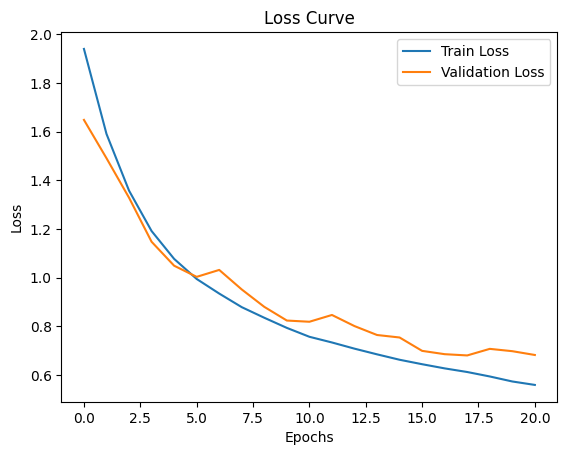

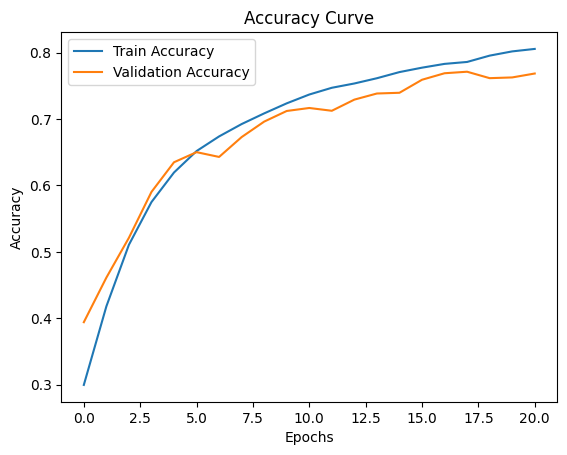

In [11]:
# Plot the training and validation accuracy and loss curves
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()

plot_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [14]:
def test(model, test_loader):
    model.eval()  # Setting the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Test function
test(model, test_loader)


Test Accuracy: 78.59%


AlexNet and MobileNet

In [17]:
import torchvision.models as models
import torch.nn as nn

# Loading AlexNet with modifications for CIFAR-10 (32x32 input size)
class CIFAR10AlexNet(nn.Module):
    def __init__(self):
        super(CIFAR10AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# Modified AlexNet model
alexnet = CIFAR10AlexNet().to(device)


# Loading MobileNetV2 with modifications for CIFAR-10
mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)  # CIFAR-10 has 10 classes

# Moving models to device
alexnet = alexnet.to(device)
mobilenet = mobilenet.to(device)


In [18]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()

# Train and test AlexNet
alexnet_optimizer = torch.optim.Adam(alexnet.parameters(), lr=learning_rate)
train_losses, val_losses, train_accuracies, val_accuracies = train(alexnet, train_loader, val_loader, alexnet_optimizer, criterion, num_epochs)
test(alexnet, test_loader)

# Train and test MobileNetV2
mobilenet_optimizer = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate)
train_losses, val_losses, train_accuracies, val_accuracies = train(mobilenet, train_loader, val_loader, mobilenet_optimizer, criterion, num_epochs)
test(mobilenet, test_loader)


Epoch [1/10], Train Loss: 1.8207,  Train Accuracy: 0.3082, Val Loss: 1.5406, Val Accuracy: 0.4206
Epoch [2/10], Train Loss: 1.4562,  Train Accuracy: 0.4686, Val Loss: 1.3094, Val Accuracy: 0.5194
Epoch [3/10], Train Loss: 1.2773,  Train Accuracy: 0.5413, Val Loss: 1.1467, Val Accuracy: 0.5897
Epoch [4/10], Train Loss: 1.1517,  Train Accuracy: 0.5910, Val Loss: 1.0865, Val Accuracy: 0.6117
Epoch [5/10], Train Loss: 1.0766,  Train Accuracy: 0.6219, Val Loss: 0.9845, Val Accuracy: 0.6462
Epoch [6/10], Train Loss: 1.0081,  Train Accuracy: 0.6479, Val Loss: 0.9345, Val Accuracy: 0.6717
Epoch [7/10], Train Loss: 0.9562,  Train Accuracy: 0.6672, Val Loss: 0.8896, Val Accuracy: 0.6836
Epoch [8/10], Train Loss: 0.9052,  Train Accuracy: 0.6870, Val Loss: 0.8359, Val Accuracy: 0.7132
Epoch [9/10], Train Loss: 0.8675,  Train Accuracy: 0.7001, Val Loss: 0.8628, Val Accuracy: 0.6952
Epoch [10/10], Train Loss: 0.8337,  Train Accuracy: 0.7132, Val Loss: 0.8192, Val Accuracy: 0.7138
Test Accuracy: 73.4

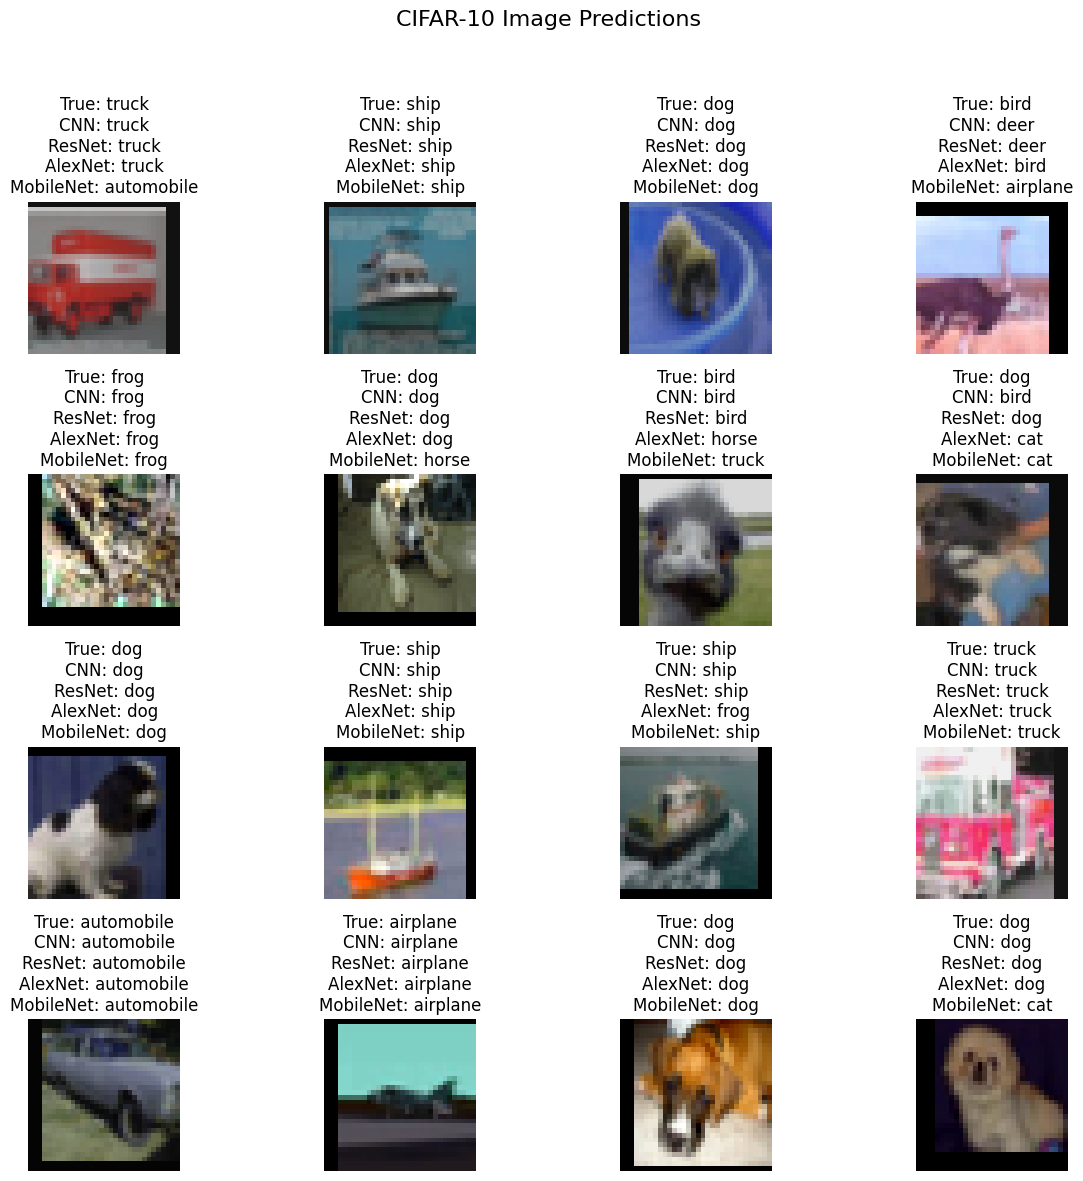

In [21]:
# Function to unnormalize the images for display
def unnormalize(img):
    img = img / 2 + 0.5  # unnormalize
    return np.transpose(img.numpy(), (1, 2, 0))

# Ensure models are in evaluation mode
baseline_model.eval()
model.eval()
alexnet.eval()
mobilenet.eval()

# Move models to the appropriate device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#cnn_model.to(device)
#resnet_model.to(device)
#alexnet_model.to(device)
#mobilenet_model.to(device)

# Move images to the same device
images = images.to(device)

# Make predictions with each model
with torch.no_grad():
    cnn_preds = baseline_model(images).argmax(dim=1)
    resnet_preds = model(images).argmax(dim=1)
    alexnet_preds = alexnet(images).argmax(dim=1)
    mobilenet_preds = mobilenet(images).argmax(dim=1)

# Display the images with actual and predicted labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("CIFAR-10 Image Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(unnormalize(images[i].cpu()))
    actual_label = classes[labels[i]]
    cnn_label = classes[cnn_preds[i]]
    resnet_label = classes[resnet_preds[i]]
    alexnet_label = classes[alexnet_preds[i]]
    mobilenet_label = classes[mobilenet_preds[i]]

    # Set title with actual and predicted labels for each model
    ax.set_title(f"True: {actual_label}\n"
                 f"CNN: {cnn_label}\n"
                 f"ResNet: {resnet_label}\n"
                 f"AlexNet: {alexnet_label}\n"
                 f"MobileNet: {mobilenet_label}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()